# Preparing Dataset

In [3]:
import pandas as pd
import numpy as np
import torch
import os
import numpy as np
from rdkit import Chem
from torch.utils.data import DataLoader
from KAE_library.DataUtilities import prepare_data, CustomDataset

zinc = pd.read_csv('250k.csv') # If you run this the first time, you just need to change the directory.
smiles = np.array([s[:-1] for s in zinc.smiles.values]) # Creating an array of strings
properties = zinc[['logP','qed','SAS']].values[:,0] # Creating an array of conditions in floats


In [4]:

if('cpth_data.pkl' in os.listdir()):
    batch,batch_test,smiledict,invdict,csv,smilenames = prepare_data(smiles, properties, load_from_pickle_directory = 'cpth_data.pkl', token_threshold = 200)
else:
    # If you are running this the first time, you will get the see the maxlength of the seuqnces
    batch,batch_test,smiledict,invdict,csv,smilenames = prepare_data(smiles, properties, load_from_pickle_directory = None, token_threshold = 200)

Read Checkpoint File Complete.



In [5]:

maxlength = 113 # If your maxlength is differnt, chaneg this variable

dataset = CustomDataset(batch, maxlength = maxlength)

batch_size = 128
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=1)


# Constructing Encoder, Decoder and Seq2Seq style framework

In [6]:
from KAE_library.EncoderClass import Encoder
from KAE_library.DecoderClass import Decoder
from KAE_library.S2SFramework import Seq2Seq

torch.manual_seed(8)

n_cat= 1 # using only one condition

INPUT_DIM = len(smiledict) + 5  +  n_cat# adding the number of categories
OUTPUT_DIM = len(invdict) # This is the number of categories that decoder outputs
HID_DIM =  128
ENC_LAYERS = 6
DEC_LAYERS = 6
ENC_HEADS = 4 # HID_DIM must be integer devisible by head
DEC_HEADS = 4
ENC_PF_DIM = 2*HID_DIM # Encoder positional feedforward expansion dimension
DEC_PF_DIM = 2*HID_DIM # Decoder positional feedforward expansion dimension

ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

bottle_len = 10

device = 'cuda:0'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              num_categories = 1,
              max_length = 220, # This maxlength is the maxlength that positional embedding allows
              data_maxlength = mxalength # This maxlength is the absolute maxlength that exist in the dataset
              
              )

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              max_length = 220
              )


pad_index = len(smiledict)
model = Seq2Seq(enc, dec, pad_index, pad_index, device, bottle_len = bottle_len, data_maxlength = 113)#.to(device)
model = torch.nn.DataParallel(model,device_ids= [i for i in range(torch.cuda.device_count())] ).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
           
    


The model has 5,504,410 trainable parameters


# Loading Checkpoint

In [7]:
model.load_state_dict(torch.load('L35D1_MMD_model_epoch400.pth'))

<All keys matched successfully>

# Testing Model Generation Performance

In [8]:
from KAE_library.GenerationFunctions import *

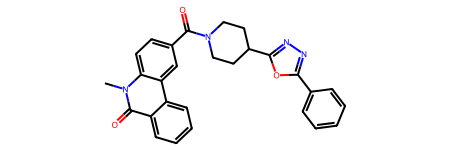

In [12]:
trg_mol = 'C(=O)(N1CCC(CC1)c1nnc(o1)c1ccccc1)c1cc2c(n(c(=O)c3ccccc23)C)cc1'
trg_mol = Chem.MolToSmiles(Chem.MolFromSmiles(trg_mol), isomericSmiles=True)
tokens = [smiledict['!']] + [smiledict[s] for s in trg_mol] + [smiledict['?']]
for _ in range(maxlength - 1 - len(tokens)):
    tokens.append(len(smiledict))
tokens.append(0)
#tokens
z = translate_sentence(src = torch.LongTensor(tokens).to(device).view(1,-1), 
                       model = model.module, 
                       device = device, 
                       smiledict = smiledict,
                       invdict = invdict, 
                       max_len=113, 
                       randz=False, 
                       return_Z=False, 
                       C=None) # Obtain the latent representation of the target molecule.
Chem.MolFromSmiles(trg_mol) # Plotting this molecule

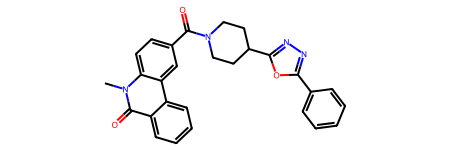

In [13]:
Chem.MolFromSmiles(z)

In [14]:
z = translate_sentence(src = torch.LongTensor(tokens).to(device).view(1,-1), 
                       model = model.module, 
                       device = device, 
                       smiledict = smiledict,
                       invdict = invdict, 
                       max_len=113, 
                       randz=False, 
                       return_Z=True, 
                       C=None) # Obtain the latent representation of the target molecule.

In [15]:
all_result = []
rounds = 10
for _ in tqdm(range(rounds)):
    z_ = z + 0.5*torch.randn_like(z) # control the range of sampling.
    beam_result = Batch_Beam_Generate_Z(z_,model.module, device, smiledict, invdict, max_len=113, randz=False, C=None, beam_size=10)
    #beam_result = Batch_Beam_Generate_Z(z_, model.module, device, max_len = 220, randz = False, C = None, beam_size = 10)
    all_result += (beam_result[0])
nuv_outputs,_ = get_valid_unique(all_result,smilenames)
print('NUV:',len(nuv_outputs))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

NUV: 56


In [16]:
from rdkit.Chem import Draw

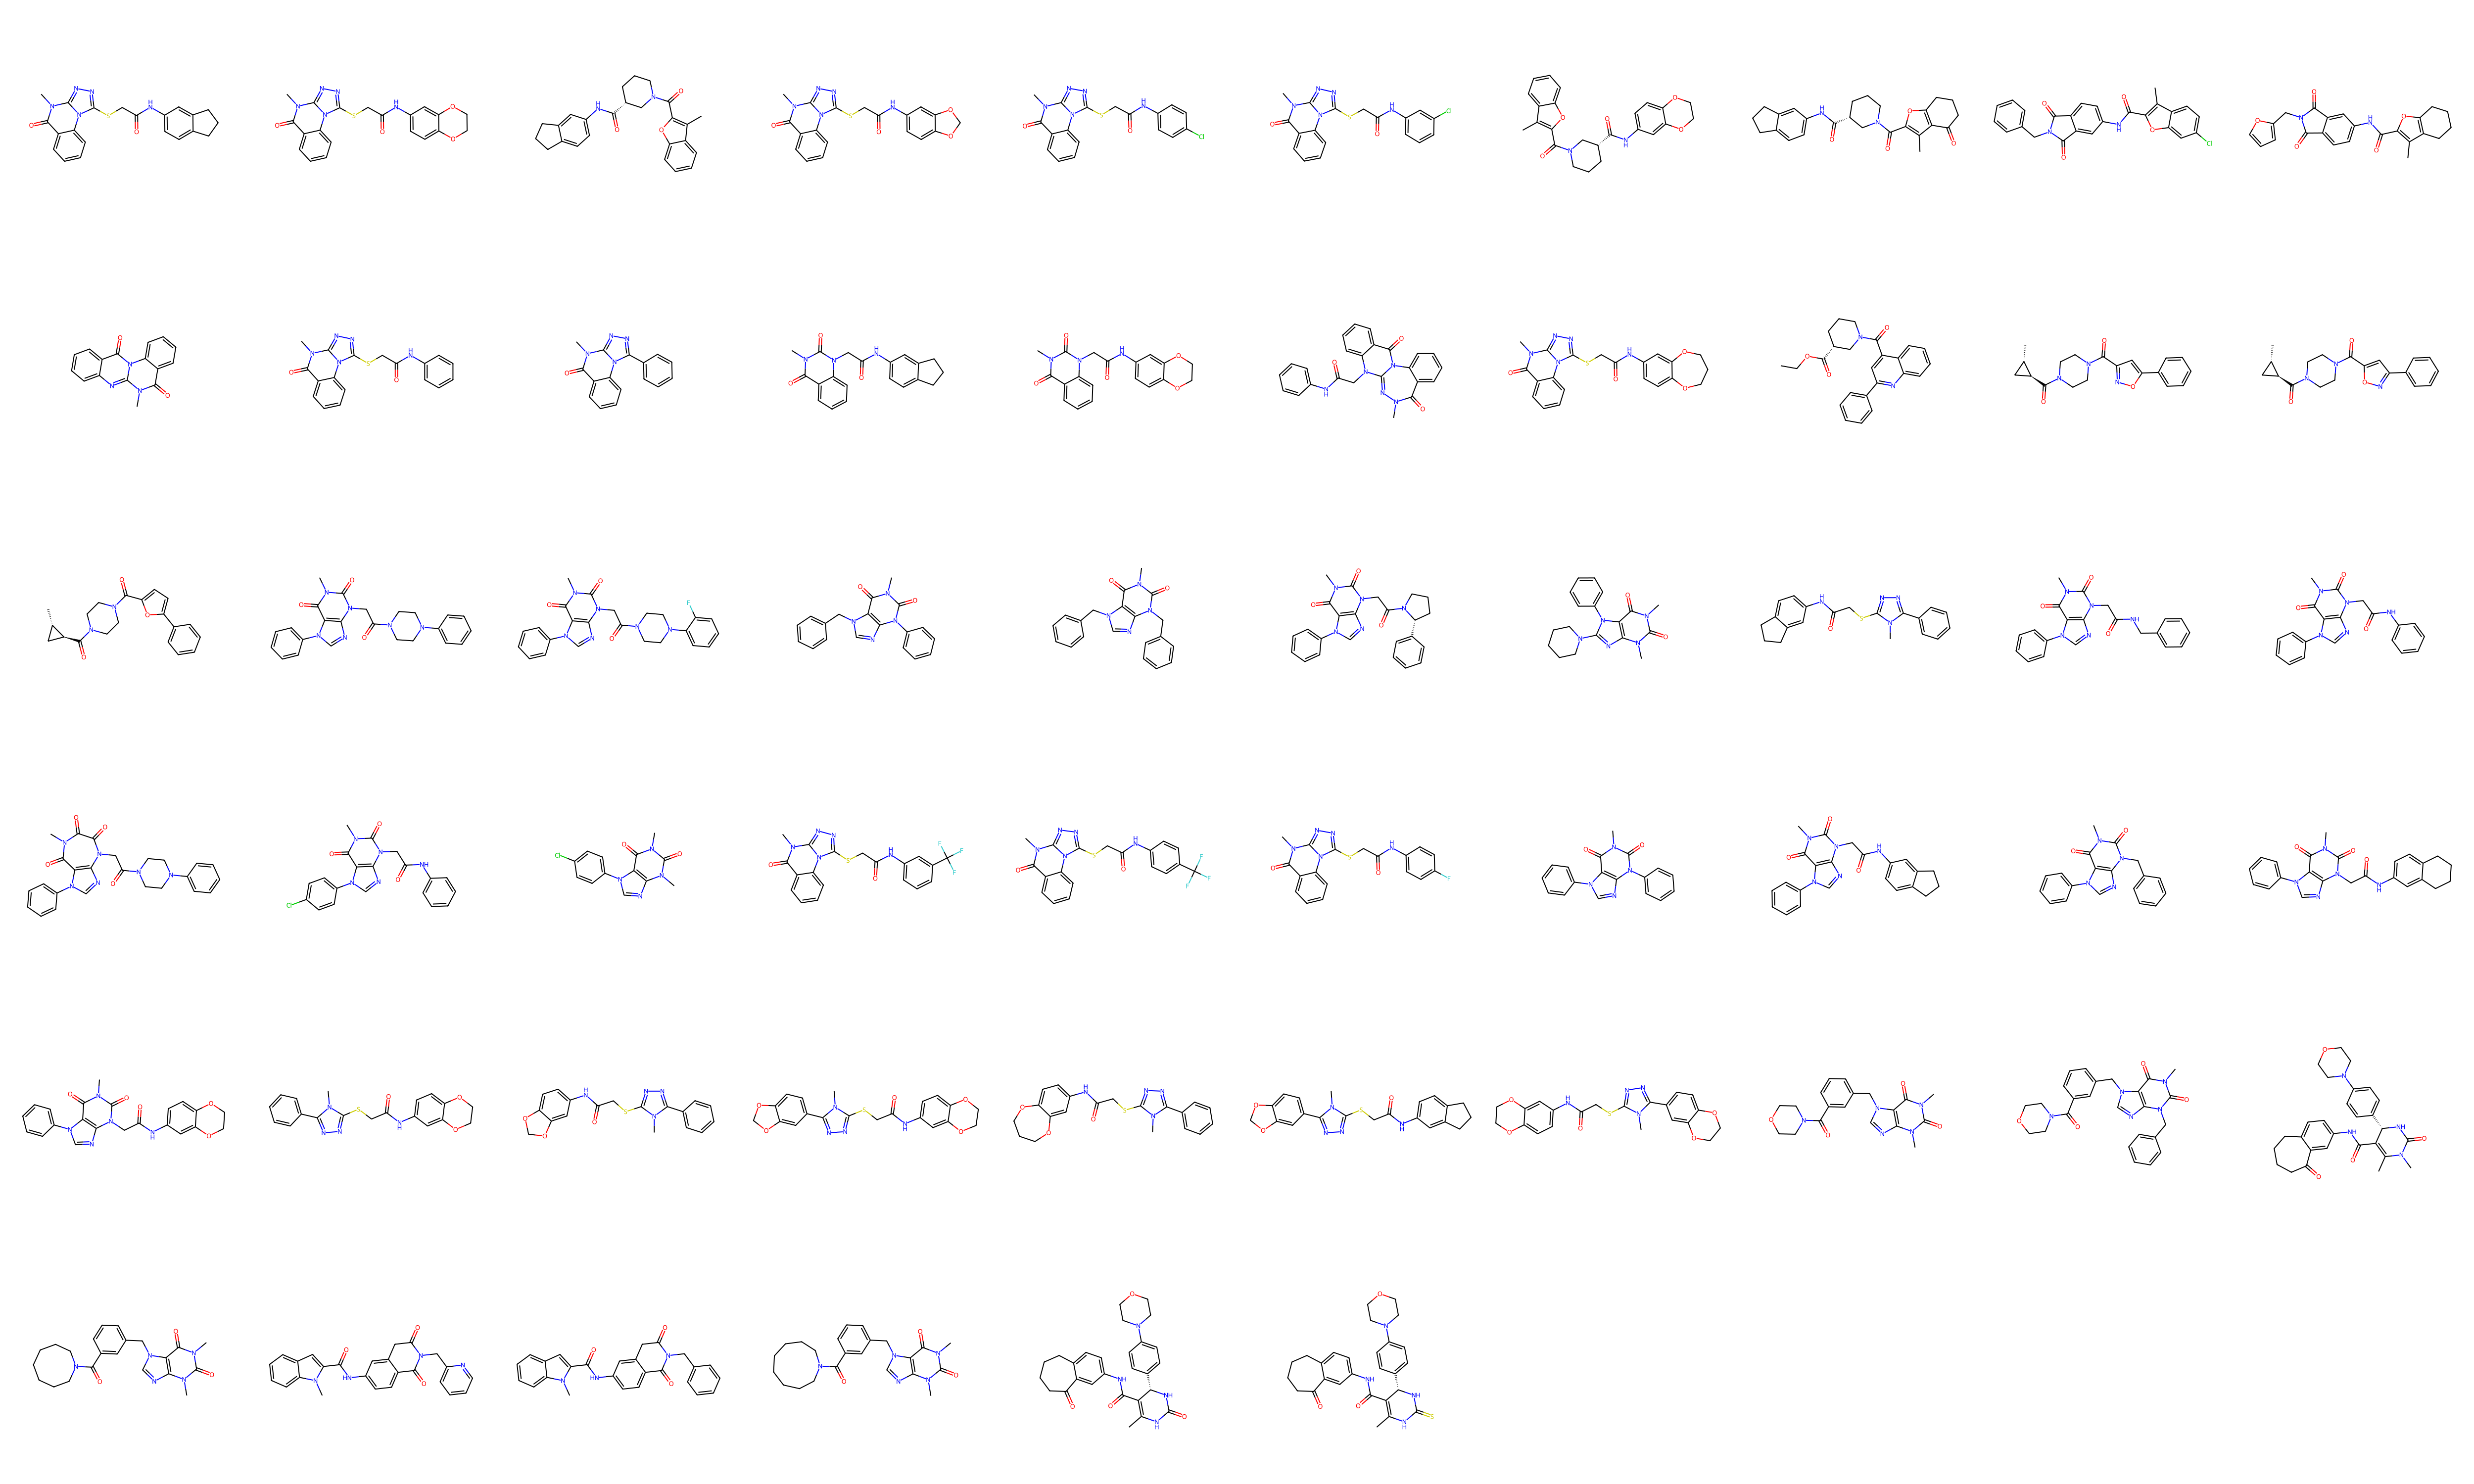

In [17]:
ms = [Chem.MolFromSmiles(mol) for mol in nuv_outputs]

img = Draw.MolsToGridImage(ms,molsPerRow=10,subImgSize=(500,500),maxMols = 100)
img

# Training Model

In [18]:
from KAE_library.TrainKAE import train

In [19]:
criterion = nn.CrossEntropyLoss(ignore_index = len(smiledict),reduction = 'none')

In [20]:
optimizer = torch.optim.Adam(model.parameters(),lr = 2e-4)

In [21]:
train

<function KAE_library.TrainKAE.train(model, device, train_batch, optimizer, criterion, clip, n_cat, bottle_len, HID_DIM)>

In [22]:
train(model, device = device, train_batch = train_loader,optimizer = optimizer, criterion = criterion, clip = 1.0, n_cat = n_cat, bottle_len = bottle_len,HID_DIM = HID_DIM)

Loss: 0.9381549954414368
Rec Loss  0.18126043677330017
MMD LOSS: 0.7954195737838745
Rec Loss No Noise 0.1234729066491127
Loss: 0.8528298735618591
Rec Loss  0.1539168804883957
MMD LOSS: 0.7995047569274902
Rec Loss No Noise 0.003029201878234744
Loss: 0.8500751852989197
Rec Loss  0.14394095540046692
MMD LOSS: 0.8011904954910278
Rec Loss No Noise 0.0013565827393904328
Loss: 0.8515827059745789
Rec Loss  0.14571411907672882
MMD LOSS: 0.8013608455657959
Rec Loss No Noise 0.002475765999406576
Loss: 0.849915623664856
Rec Loss  0.13964228332042694
MMD LOSS: 0.8022284507751465
Rec Loss No Noise 0.0017096070805564523
Loss: 0.8473259210586548
Rec Loss  0.13463564217090607
MMD LOSS: 0.8019471168518066
Rec Loss No Noise 0.0007504326058551669
Loss: 0.8510831594467163
Rec Loss  0.13970762491226196
MMD LOSS: 0.8034982681274414
Rec Loss No Noise 0.0015235169557854533
Loss: 0.8499130010604858
Rec Loss  0.1379646360874176
MMD LOSS: 0.802862286567688
Rec Loss No Noise 0.0015937770949676633
Loss: 0.847633898